In [1]:
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.exceptions import RestException
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from mlflow.models.signature import infer_signature
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import argparse

In [2]:
# 引数の処理
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--n_estimators", type=int, default=100, help="Number of trees in the forest")
    parser.add_argument("--max_depth", type=int, default=10, help="Max depth of the trees")
    
    # parse_known_args()を使ってJupyterの不要な引数を無視
    args, unknown = parser.parse_known_args()
    return args

# 引数を取得
args = parse_args()

# MLflowの設定
mlflow.set_tracking_uri("http://mlflow:5000")
mlflow.set_experiment("California Housing Price Prediction")

# モデル名を定義
model_name = "CaliforniaHousingModel"

# California Housing用の実験名を設定
mlflow.set_experiment("California Housing Price Prediction")

# データの読み込みと分割
california_housing = fetch_california_housing()
X = california_housing.data
y = california_housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 実行ごとに一意の名前を持たせるとより追跡が容易になります
run_name = f"RF Regressor Experiment {time.strftime('%Y-%m-%d %H:%M:%S')}"

# ハッシュ関数でデータバージョン管理
def get_data_hash(data):
    return hashlib.md5(data.tobytes()).hexdigest()

# 使用例: 引数を表示
print(f"Number of estimators: {args.n_estimators}")
print(f"Max depth: {args.max_depth}")

2025/01/30 13:38:58 INFO mlflow.tracking.fluent: Experiment with name 'California Housing Price Prediction' does not exist. Creating a new experiment.


Number of estimators: 100
Max depth: 10


Registered model 'CaliforniaHousingModel' already exists. Creating a new version of this model...
2025/01/30 13:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CaliforniaHousingModel, version 1


モデル CaliforniaHousingModel を新規登録しました。
モデルバージョン 1 が作成されました。


Created version '1' of model 'CaliforniaHousingModel'.


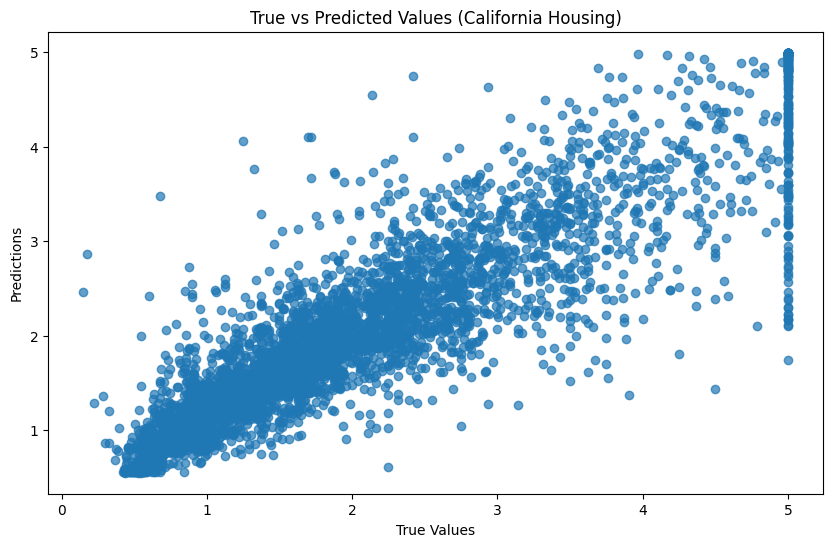

In [3]:
# 実行（Run）の開始
with mlflow.start_run() as run:
    # モデルの構築と評価
    n_estimators = 100
    max_depth = 10
    random_state = 42

    # ランダムフォレスト回帰モデルの作成
    reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    # 評価メトリクスの計算
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # パラメータとメトリクスの記録
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2_score", r2)

    # データバージョン管理
    data_hash = get_data_hash(X_train)
    mlflow.log_param("data_hash", data_hash)

    # シグネチャの推論
    signature = infer_signature(X_train, y_pred)

    # 入力例の指定
    input_example = X_train[:5]  # 入力データの最初の5行をサンプルとして使用

    # アーティファクトの保存先を指定
    run_id = run.info.run_id
    experiment_id = run.info.experiment_id
    artifacts_dir = os.path.join("mlruns", str(experiment_id), str(run_id), "artifacts")

    # artifactsディレクトリを作成（存在しない場合）
    os.makedirs(artifacts_dir, exist_ok=True)

    # プロットの作成と保存
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True vs Predicted Values (California Housing)')
    
    # プロットをアーティファクトディレクトリに保存
    plot_path = os.path.join(artifacts_dir, "true_vs_predicted.png")
    plt.savefig(plot_path)

    # アーティファクトの記録
    mlflow.log_artifact(plot_path)

    # モデルの保存時にシグネチャと入力例を指定
    mlflow.sklearn.log_model(
        sk_model=reg,
        artifact_path="random_forest_regressor_model",
        signature=signature,
        input_example=input_example
    )

    # モデル登録の処理
    client = MlflowClient()
    model_name = "CaliforniaHousingModel"
    
    try:
        # モデルの登録を試みる
        client.create_registered_model(model_name)
        print(f"モデル {model_name} を新規登録しました。")
    except RestException as e:
        # モデルがすでに存在する場合は新しいバージョンを作成
        if "RESOURCE_ALREADY_EXISTS" in str(e):
            print(f"モデル {model_name} はすでに存在します。新しいバージョンを作成します。")

    # モデルバージョンを登録する
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/random_forest_regressor_model"
    result = mlflow.register_model(model_uri, model_name)
    print(f"モデルバージョン {result.version} が作成されました。")

In [4]:
artifacts_dir

'mlruns/681696901446020589/c752011dc8784ada9ba6c71e6b13aa82/artifacts'

/opt/conda/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'CaliforniaHousingModel_online' already exists. Creating a new version of this model...
2025/01/31 01:21:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CaliforniaHousingModel_online, version 1


モデル CaliforniaHousingModel_online を新規登録しました。
モデルバージョン 1 が作成されました。


Created version '1' of model 'CaliforniaHousingModel_online'.


In [3]:
# modelをオンライン学習可能なSGDRegressor

In [1]:
import os
import mlflow
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import SGDRegressor  # ✅ オンライン学習可能なモデル
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from mlflow.exceptions import RestException

# データ取得
data = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

# オンライン学習可能なSGDRegressorを使用
model = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))

# 初回学習
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 評価メトリクス
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# MLflow ログ
mlflow.set_tracking_uri("http://mlflow:5000")
model_name = "CaliforniaHousingModel_onlinetraining"

with mlflow.start_run() as run:
    mlflow.log_param("max_iter", 1000)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2_score", r2)

    # シグネチャ & 入力サンプル
    signature = infer_signature(X_train, y_pred)
    input_example = X_train[:5]

    # モデルの保存
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path=model_name,  # 一貫性を持たせる
        signature=signature,
        input_example=input_example
    )

    # モデル登録処理
    client = MlflowClient()

    try:
        client.create_registered_model(model_name)
        print(f"モデル {model_name} を新規登録しました。")
    except RestException as e:
        if "RESOURCE_ALREADY_EXISTS" in str(e):
            print(f"モデル {model_name} はすでに存在します。新しいバージョンを作成します。")

    # モデルバージョンを登録
    model_uri = f"runs:/{run.info.run_id}/{model_name}"
    result = mlflow.register_model(model_uri, model_name)
    print(f"モデルバージョン {result.version} が作成されました。")


Registered model 'CaliforniaHousingModel_onlinetraining' already exists. Creating a new version of this model...
2025/01/31 09:00:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CaliforniaHousingModel_onlinetraining, version 3


モデル CaliforniaHousingModel_onlinetraining はすでに存在します。新しいバージョンを作成します。
モデルバージョン 3 が作成されました。


Created version '3' of model 'CaliforniaHousingModel_onlinetraining'.
